# Outlier Removal & Dimentionality Reduction
## Selecting demographic variables



This notebook employs t-tests to select `demographic variables`: by testing whether or not statistically significant differences are observable in average perfomance of `wcst` between difference demographic groups.

Where statistical difference are observed, one would like to keep the demographic information in the model. However, where no significant relationship can be drawn, it it is best to remove the superfluous parameters for parsimony.

---------
```
author:         Zach Wolpe
email:          zachcolinwolpe@gmail.com
reviewer:       n/a
date:           11 Dec 2021
```
---------

In [1]:
import sys
sys.path.append('../process data')
from dependencies import *
# import nbformatx

In [2]:
# load data --------------*
with open('../data objects/batch_processing_object_with_encodings.pkl', 'rb') as file2: bp = pickle.load(file2)

# create object ----------*
spf = summary_plots_and_figures(bp)

# view keys --------------*
def show_keys(obj, name):
    print('')
    print(name + ' object attributes: ')
    for k in obj.__dict__.keys():print('   -', k)

# show_keys(bp, 'ed')
# show_keys(bp.raw, 'bp')
# show_keys(spf, 'spf')

# WCST

Remove incomplete data from the dataset. One form inconsistency is extremely low WCST perfomance scores. Since we are not studying subjects with mental defects, it is highly unlikely that an individual subject achieves a very low score for the WCST. The task is a relatively simple, and thus it is natural to assume that exceedling low scores are purely a consequence of negligance or false completing the task as quickly as possible to receive payment. The experiments were conducted on Amazon's Mechanical Turk, thus it is possible that some participants did not fully engage in the operation but rather speedly choose any option to complete the test.

We this ought to set a threshold, marking subjects whom score under which as null and void, disgarding their data from the analysis as it does not capture a try reflection of the individuals cognitive performance.

The same logic may be applied to many other tasks, though is most important for the WCST as this forms the basis under which many other dimensionality reduction techniques are employed.


## Decision Threshold

The decision was taken to remove all participants whom scored under $0.4$ for the WCST task. This is a plausible threshold given the complexity of the task, and removes about $10%$ of the participants.

$$\lambda_{wcst}=0.4$$

In [3]:

# subset dataset ---------*
df = bp.summary_table.copy()
df = df.reset_index()[['participant', 'wcst_accuracy']].drop_duplicates()
df = df.set_index('participant').dropna()

# compute cummulative threshold exceedence ---------*
thresholds = []
percentage_below = []
for thresh in np.linspace(0,1,1000):
    thresholds.append(thresh)
    percentage_below.append((df < thresh).mean()[0])

# create df ---------*
thresholds_df = pd.DataFrame({'thresholds':thresholds, 'percentage_below':percentage_below})
thresholds_df[(thresholds_df.thresholds<0.41) & (thresholds_df.thresholds>0.39)]

# visualize ---------*
fig_theshold = px.line(x=thresholds, y=percentage_below, template='none')
fig_theshold.add_vline(x=0.4, line_width=3, line_dash="dash", line_color="darkred")
fig_theshold.update_layout(title='Threshold Exceedance',  xaxis_title='threshold', yaxis_title='cummulative %')
fig_theshold.show()

In [4]:
# general plot ---------*
def plot_threshold(df, variable, threshold, var_name=None, colour='steelblue'):
    df = df.copy()
    df = df.reset_index()[['participant', variable]].drop_duplicates()
    df = df.set_index('participant').dropna()
    below = round(np.mean(df[variable] < threshold), 3)
    if not var_name: var_name=variable
    fig = px.histogram(df, x=variable, marginal="box", template='none', title=f'{var_name}: % subjects below threshold={below}', color_discrete_sequence=[colour])
    fig.add_vline(x=threshold, line_width=3, line_dash="dash", line_color="darkred")
    return fig


In [5]:
# wcst distribution ---------*
fig_wcst_dist = plot_threshold(df, variable='wcst_accuracy', threshold=0.4)
fig_wcst_dist.show()
fig_theshold.show()

In [6]:
# psychological variables
columns = ['nback_status', 'nback_reaction_time_ms', 'fitts_mean_deviation', 'corsi_block_span', 'navon_level_of_target', 'navon_perc_correct', 'navon_reaction_time_ms', 'wcst_accuracy', 'wcst_RT']

# colours
clrs = ['#1a3dea', '#fbab75', '#2180c7', 'indigo-red', '#7ba053', '#ffc34c', '#006b68', '#537fbb', '#80c080', '#537fbb']


# Demographics

Since demographic data is primarily playing a supporting role in the analysis, before looking for interaction effects in the model we will remove demographic variables that offer no independent explanatory power over the response (WCST)

### Phase 1: Implementation

1. $Hyperparameters$:   For $m$ in $1:n$ (where $n$ is the number of demographic variables).
2. $Train-test-split$:  Split the data into training and testing modules.
2. $mRMR$:              Use mRMR on the training set to find the best $K$ variables.
3. $Model$:             Fit the models to the training subset.
4. $Evaluate$:          Evaluate the performance by some suite of metrics.


### Phase 2: Determine Optimal K 

1. $Assess$:            Measure how the performance decays in the number of covarates selected *K*.
2. $Select \ K$:        Use an *elbow* like method to determine the optimal number of covariates: where performance either plateau or decays.


### Phase 3. Determine the best K covariates

1. $Final Selection$:   Using the chosen $K$, utilize $mRMR$ to select the optimal variables.



-----

## Models

$3$ models are used, to represent different model families & thus aggregating results may allow for generalizable results. The 3 models:

- Linear Regression
- SVM regression
- Random Forrest regression


## Metrics

- $RMSE$
- Adjusted $R^2$
- $BIC$


In [7]:
# Filter dataset  ------------------------------------------------------------------------------------------------------------------------------*
def filter_dataset(data=bp.summary_table, wcst_thresold=0.4, dropna=True, drop_duplicates=True, vars=['wcst_accuracy']):
    df = data[vars].copy()
    df = df.loc[df['wcst_accuracy'] > wcst_thresold, :]
    if dropna:          df = df.dropna()
    if drop_duplicates: df = df.drop_duplicates()
    return df



# create dataset -------------*
vars = [
    'wcst_accuracy', 'wcst_RT', 'demographics_age_a', 'demographics_gender_a', 'demographics_handedness_a', 'demographics_education_a',
    'demographics_income_a', 'demographics_computer_hours_a', 'demographics_age_group', 'demographics_mean_reation_time_ms']
df = filter_dataset(vars=vars)



# scatter matrix -------------*
discrete = ['demographics_gender_a', 'demographics_handedness_a']
discrete = ['demographics_gender_a', 'demographics_handedness_a']

vars = ['wcst_accuracy', 'wcst_RT', 'demographics_age_a', 'demographics_gender_a']
vars = ['wcst_accuracy', 'wcst_RT', 'demographics_handedness_a', 'demographics_education_a']
vars = ['wcst_accuracy', 'wcst_RT', 'demographics_income_a', 'demographics_computer_hours_a']
vars = ['wcst_accuracy', 'wcst_RT', 'demographics_age_group', 'demographics_mean_reation_time_ms']

vars = ['wcst_accuracy', 'wcst_RT', 'demographics_age_a']


fig = px.scatter(df, x='wcst_RT', y='wcst_accuracy', color='demographics_age_a', facet_col='demographics_gender_a', facet_row='demographics_handedness_a')
fig = px.scatter(df, x='demographics_age_a', y='wcst_accuracy', color='demographics_gender_a')

fig.update_layout(template='none')
fig.show()


In [17]:
# Create dataset ------------------------------------------------------------------------------------------------------------------------------------------*
vars         = ['wcst_accuracy', 'wcst_RT', 'demographics_age_a', 'demographics_gender_a', 'demographics_handedness_a', 'demographics_education_a',
                'demographics_income_a', 'demographics_computer_hours_a', 'demographics_age_group', 'demographics_mean_reation_time_ms']
cat_features = ['demographics_gender_a', 'demographics_handedness_a', 'demographics_education_a', 'demographics_age_group']
num_features = ['demographics_age_a', 'demographics_income_a', 'demographics_computer_hours_a', 'demographics_mean_reation_time_ms']
df           = filter_dataset(vars=vars)

# Remove erroneous or missing data ------------------------------------------------------------------------------------------------------------------------*
df = df.loc[df.demographics_gender_a        != 'other',:]
df = df.loc[df.demographics_handedness_a    != 'ambidextrous',:]

# train-test split ----------------------------------------------------------------------------------------------------------------------------------------*
X_train = df.iloc[:,2:]
y_train = df.iloc[:,0]
X, y = X_train, y_train

X_train.head()

,demographics_age_a,demographics_gender_a,demographics_handedness_a,demographics_education_a,demographics_income_a,demographics_computer_hours_a,demographics_age_group,demographics_mean_reation_time_ms
participant,,,,,,,,
100934.0,28.0,male,right,university,7.0,25.0,25-34,11453.571429
103322.0,51.0,male,right,university,6.0,82.0,45-54,5294.428571
107700.0,35.0,male,right,university,4.0,4.0,25-34,4175.714286
117200.0,39.0,male,right,university,3.0,34.0,35-44,3637.142857
117306.0,28.0,male,right,university,3.0,5.0,25-34,7471.142857


In [18]:
from mrmr import mrmr_regression


results = {}
for relevance in ['f', 'rf']: 
    # both relevance methods

    store = {}
    for K in range(1, X_train.shape[1]+1):
        # for each K
        mrmr = mrmr_regression(X=X_train, y=y_train, cat_features=cat_features, relevance=relevance, K=K)
        store[str(K)] = mrmr
    
    results[relevance] = store

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


In [10]:
results.keys(), results['f'].keys()

(dict_keys(['f', 'rf']), dict_keys(['1', '2', '3', '4', '5', '6', '7', '8']))

In [311]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin

import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import Ridge

from sklearn.linear_model import RidgeCV, SGDRegressor, BayesianRidge, ElasticNetCV, LarsCV, LassoCV, LassoLars, LassoLarsCV, LassoLarsIC

In [312]:


class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        return self
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)
    def test(self, X):
        print('yea whaever so awesome!')

In [313]:

# variables -----*
cat_features = ['demographics_gender_a', 'demographics_handedness_a', 'demographics_education_a', 'demographics_age_group']
num_features = ['demographics_age_a', 'demographics_income_a', 'demographics_computer_hours_a', 'demographics_mean_reation_time_ms']

# numeric tranformer -----*
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])

# categorical tranformer -----*
categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop='first')


# # transformer class -----*
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, num_features),
#         ('cat', categorical_transformer, cat_features)
#     ]
# )



In [344]:
# function to compute mrmr & model given model class ------------------------------------------------------*
def compute_mrmr(model) -> pd.DataFrame():
    """
    Return: A pd.DataFrame containing the results of fitting the model to the subset choosen by mrmr.
    """
    None
    # store hyperparameters ------*
    mrmr_class  = []
    mrmr_n_vars = []
    mse_list    = []
    r2_list     = []

    for mrmr_type in results.keys():
        for key in results[mrmr_type].keys():
            # filter for mrmr select variables ---------------*
            covariates  = results[mrmr_type][key]
            X_          = X[covariates]


            # filter variable list ---------------------------*
            cat_features_ = [c for c in covariates if c in cat_features]
            num_features_ = [c for c in covariates if c in num_features]


            # create model pipeline --------------------------*
            # transformer class -----*
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, num_features_),
                    ('cat', categorical_transformer, cat_features_)
                ]
            )

            # fit model --------------------------------------*
            X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, random_state=0)
            reg = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", model)])
            reg.fit(X_train, y_train)
            y_pred  = reg.predict(X_test)
            r2      = r2_score(y_true=y_test, y_pred=y_pred)
            mse     = mean_squared_error(y_true=y_test, y_pred=y_pred)


            # store results ---------------*
            mrmr_class.append(mrmr_type)
            mrmr_n_vars.append(key)
            mse_list.append(mse)
            r2_list.append(r2)
            if False:
                print("model score: %.3f" % reg.score(X_test, y_test))
                print(f'R-squared: {r2}')
                print(f'Mean squared error: {mse}')
            
            # create data frame ---------------*
    return pd.DataFrame({'mrmr_class':mrmr_class, 'n_vars':mrmr_n_vars, 'mse':mse_list, 'r2':r2_list})


In [354]:
# store results ------------------------------------------------------*
# rnd_forrest_mse = []
# rnd_forrest_r2  = []
# svm_mse = []
# svm_r2  = []
# GBR_mse = []
# GBR_r2  = []
# GBR_mse = []
# GBR_r2  = []
# LR_mse  = []
# LR_r2   = []




results.keys(), results['f'].keys()

models = [
    LinearRegression(), RandomForestRegressor(max_depth=5), GradientBoostingRegressor(), GaussianProcessRegressor(), Ridge(), RidgeCV(), 
    SGDRegressor(), ElasticNetCV(), LarsCV(), LassoCV(), LassoLars(), LassoLarsCV(), LassoLarsIC(), SVR()]

# models = [LassoLarsIC(), SVR()]
model_results = {}

for model in tqdm(models):
    model_name = str(model).split('(')[0]       # str
    comp_mrmr = compute_mrmr(model)             # compute
    model_results[model_name] = comp_mrmr       # store


model_results.keys()

100%|██████████| 14/14 [00:02<00:00,  6.36it/s]


dict_keys(['LinearRegression', 'RandomForestRegressor', 'GradientBoostingRegressor', 'GaussianProcessRegressor', 'Ridge', 'RidgeCV', 'SGDRegressor', 'ElasticNetCV', 'LarsCV', 'LassoCV', 'LassoLars', 'LassoLarsCV', 'LassoLarsIC', 'SVR'])

In [357]:
def plot(df, metric='mse', model_name=None):
    fig = px.line(df, x='n_vars', y=metric, color='mrmr_class', template='none')
    if model_name: fig.update_layout(title=model_name + ' ~ mRMR')
    return fig


for mod in model_results.keys():
    plot(model_results[mod], model_name=mod)# .show()

In [ ]:
# ------- using other variables ------x


# variables -----*
cat_features = ['demographics_gender_a', 'demographics_handedness_a', 'demographics_education_a', 'demographics_age_group']
num_features = ['demographics_age_a', 'demographics_income_a', 'demographics_computer_hours_a', 'demographics_mean_reation_time_ms']

# numeric tranformer -----*
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])

# categorical tranformer -----*
categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop='first')


In [364]:
# filter_dataset(vars=vars)
bp.summary_table.head()

vars = ['wcst_accuracy', 'wcst_RT', 'nback_status', 'nback_reaction_time_ms', 'fitts_mean_deviation', 'corsi_block_span', 'navon_perc_correct', 
'navon_reaction_time_ms']

# Create dataset ------------------------------------------------------------------------------------------------------------------------------------------*
df           = filter_dataset(vars=vars)


# train-test split ----------------------------------------------------------------------------------------------------------------------------------------*
X_train = df.iloc[:,2:]
y_train = df.iloc[:,0]
X, y = X_train, y_train

X_train.head()


from mrmr import mrmr_regression


results = {}
for relevance in ['f', 'rf']: 
    # both relevance methods

    store = {}
    for K in range(1, X_train.shape[1]+1):
        # for each K
        mrmr = mrmr_regression(X=X_train, y=y_train, relevance=relevance, K=K)
        store[str(K)] = mrmr
    
    results[relevance] = store

100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


In [366]:
# variables -----*
cat_features = ['']
num_features = vars


results.keys(), results['f'].keys()

models = [
    LinearRegression(), RandomForestRegressor(max_depth=5), GradientBoostingRegressor(), GaussianProcessRegressor(), Ridge(), RidgeCV(), 
    SGDRegressor(), ElasticNetCV(), LarsCV(), LassoCV(), LassoLars(), LassoLarsCV(), LassoLarsIC(), SVR()]

# models = [LassoLarsIC(), SVR()]
model_results = {}

for model in tqdm(models):
    model_name = str(model).split('(')[0]       # str
    comp_mrmr = compute_mrmr(model)             # compute
    model_results[model_name] = comp_mrmr       # store


model_results.keys()



100%|██████████| 14/14 [00:02<00:00,  6.79it/s]


dict_keys(['LinearRegression', 'RandomForestRegressor', 'GradientBoostingRegressor', 'GaussianProcessRegressor', 'Ridge', 'RidgeCV', 'SGDRegressor', 'ElasticNetCV', 'LarsCV', 'LassoCV', 'LassoLars', 'LassoLarsCV', 'LassoLarsIC', 'SVR'])

In [367]:
for mod in model_results.keys():
    plot(model_results[mod], model_name=mod).show()

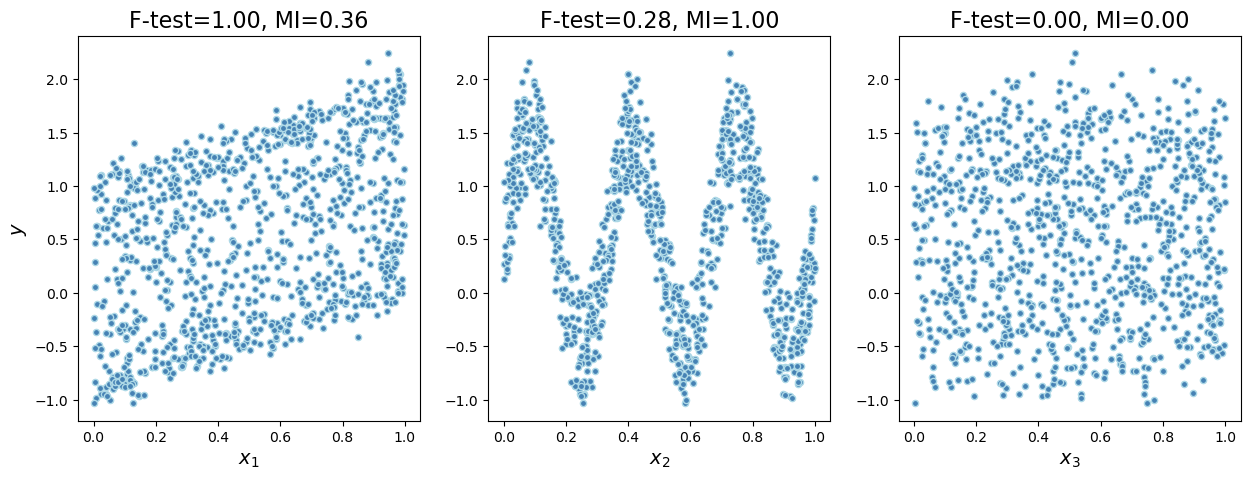

In [408]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression, mutual_info_regression, f_classif


np.random.seed(0)
X = np.random.rand(1000, 3)
y = X[:, 0] + np.sin(6 * np.pi * X[:, 1]) + 0.1 * np.random.randn(1000)

f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

plt.style.use('default')
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.scatter(X[:, i], y, edgecolor="lightblue", s=20, color='steelblue')
    plt.xlabel("$x_{}$".format(i + 1), fontsize=14)
    if i == 0:
        plt.ylabel("$y$", fontsize=14)
    plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[i], mi[i]), fontsize=16)
plt.show()

In [ ]:
from sklearn.feature_selection import f_regression, mutual_info_regression

np.random.seed(0)
X = np.random.rand(1000, 3)
y = X[:, 0] + np.sin(6 * np.pi * X[:, 1]) + 0.1 * np.random.randn(1000)

f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

In [423]:
# Create dataset ------------------------------------------------------------------------------------------------------------------------------------------*
vars         = ['wcst_accuracy', 'wcst_RT', 'demographics_age_a', 'demographics_gender_a', 'demographics_handedness_a', 'demographics_education_a',
                'demographics_income_a', 'demographics_computer_hours_a', 'demographics_age_group', 'demographics_mean_reation_time_ms']
cat_features = ['demographics_gender_a', 'demographics_handedness_a', 'demographics_education_a', 'demographics_age_group']
num_features = ['demographics_age_a', 'demographics_income_a', 'demographics_computer_hours_a', 'demographics_mean_reation_time_ms']
df           = filter_dataset(vars=bp.summary_table.columns)


def X_y_split(df, train_test=False, test_size=0.2, random_state=None):
    y = df.loc[:,['wcst_accuracy']]
    X = df.drop('wcst_accuracy', axis=1)
    if train_test:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        return X_train, X_test, y_train, y_test
    return X, y


X, y = X_y_split(df)

In [460]:
# stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', permutations=None, random_state=None, alternative='two-sided', trim=0)

covariate_list  = []
f_test_list     = []
p_value_list    = []
mi_list         = []
failed          = []

for col in X.columns:
    x = X[[col]]
    # print('col: ', col)
    try:
        try:
            # F-test: continuous ----------------------------*
            f_test, p_value = f_regression(x, y)
            
        
        except:
            # F-test: continuous ----------------------------*
            # categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop='first')
            # x = categorical_transformer.fit_transform(x)
            # f_test, p_value = f_regression(x, y)

            a = stats.ttest_ind(x, y)
            print(a)


        # Mutual information ----------------*
        mi = mutual_info_regression(x, y)

        # Store ----------------*
        covariate_list.append(col)
        f_test_list.append(f_test)
        p_value_list.append(p_value)
        mi_list.append(mi)


        # print(f'F-test: {f_test}, p-value: {p_value}')
        # print(f'Mutual information: {mi}')

    except:

        print(f'Covariate failed: {col}')
        failed.append(col)

data = pd.DataFrame({'covariate':covariate_list, 'f_test':f_test_list, 'p_value':p_value_list, 'mi':mi_list})
data  


Covariate failed: navon_level_of_target
Covariate failed: demographics_gender_a
Covariate failed: demographics_handedness_a
Covariate failed: demographics_education_a
Covariate failed: demographics_age_group


,covariate,f_test,p_value,mi
0,nback_status,[235.87461365218638],[1.5063138588717736e-45],[0.5352827837805787]
1,nback_reaction_time_ms,[16.01787148489567],[7.00914675224568e-05],[0.3485669606886903]
2,fitts_mean_deviation,[94.70050071397736],[5.772794264553179e-21],[0.3944389778432922]
3,corsi_block_span,[161.0345648754647],[4.5038909971382025e-33],[0.2656823601963447]
4,navon_perc_correct,[92.92391076809602],[1.2628513364490492e-20],[0.17160405685755586]
5,navon_reaction_time_ms,[12.570248478350983],[0.0004205307562568021],[0.23510244850616902]
6,wcst_RT,[336.25091378813886],[1.1137246313410767e-60],[0.5668757851617947]
7,demographics_age_a,[5.579642704124618],[0.01846880657851423],[0.49756465740801303]
8,demographics_income_a,[43.666637072116146],[8.203706687034019e-11],[0.2991074359765382]
9,demographics_computer_hours_a,[23.275411868850124],[1.7566383410848446e-06],[0.41690375910133515]


In [560]:
col = 'demographics_gender_a'
import statsmodels.api as sm
from statsmodels.formula.api import ols


x = df.nback_status
y = df.wcst_accuracy
sm.add_constant(x)
mod = sm.OLS(x,y).fit()

mod.fvalue

# categorical tranformer -----*
categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop='first')

x = df[['demographics_gender_a']]
y = df[['wcst_accuracy']].reset_index()[['wcst_accuracy']]
x = categorical_transformer.fit_transform(x).toarray()
x = pd.DataFrame(x)
x.shape, df.wcst_accuracy.shape
x['y'] = y

x = x.drop_duplicates()
x.columns = [str(c) for c in x.columns]
cols = [str(c) for c in x.columns if c != 'y']
x.loc[: ,cols]


moore_lm = ols('y ~ ' + ' + '.join(cols), data=x).fit()
sm.stats.anova_lm(moore_lm) 


# f_regression(x, x['y'])



,df,sum_sq,mean_sq,F,PR(>F)
Residual,74.0,1.346195,0.018192,NaN,NaN


,0,1,y
0,1.0,0.0,0.84
3,1.0,0.0,0.87
6,1.0,0.0,0.83
9,1.0,0.0,0.79
15,0.0,0.0,0.69
21,0.0,0.0,0.80
24,1.0,0.0,0.76
27,0.0,0.0,0.77
30,1.0,0.0,0.77
33,0.0,0.0,0.74


In [455]:
df[['demographics_gender_a']].shape

(642, 1)

In [72]:
# Fit models ----------------------------------------------------------------------------------------------------------------------------------------------*

X_train[mrmr]

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder


X = X_train[['demographics_gender_a', 'demographics_handedness_a']]
encoder = OneHotEncoder(drop='first') 
X = encoder.fit_transform(X).toarray()
np.shape(X)
# encoder.categories_

# encoder.categories_
#  n_samples, n_features = 10, 5
# >>> rng = np.random.RandomState(0)
# >>> y = rng.randn(n_samples)
# >>> X = rng.randn(n_samples, n_features)
# >>> regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
# >>> regr.fit(X, y)
# Pipeline(steps=[('standardscaler', StandardScaler()),
#                 ('svr', SVR(epsilon=0.2))])


(243, 4)

# Navon Task

The Navon task is primarily concern _global_ and _local_ attention. The experiment may offer two insights:

1. Do individuals with better **global** _AND_ **local** attention perform better in *WCST*.
2. Do individuals exhibit notable differences between **global** and **local** attention.


We wish to address a number of questions:

1. Does the performance in the **Navon** task map to performance in the **WCST**?
2. Is there a statistical difference in this relationship between those whom perform better at *global* attention relative to *local* attention (or visa versa)?


### Test A. Is there a difference in performance in **Global** and **Local** performance in the **Navon** task across individuals?

It is intuitive and tempting to use a _t-test_ to test whether or not the mean scores for the Navon task different significantly between groups (Global and local attention). Although particially useful, this approach negates the importance of measuring the relative difference in performance accross individuals. To assess this second (more salient) criterion, we examine the performance in _WCST_ as a function of the absolute difference between an individuals _global_ and _local_ navon performance scores. Assessing whether or not large differences in _global_ and _local_ navon scores capture any relevant information about the one's ability to perform well in the WCST.


$$Incomplete.$$


In [128]:
# Filter dataset  ------------------------------------------------------------------------------------------------------------------------------*
df = bp.summary_table[['navon_level_of_target', 'navon_perc_correct', 'navon_reaction_time_ms', 'wcst_accuracy']].copy()
df = df.loc[df['wcst_accuracy'] > 0.4, :]
df = df.dropna()


# Test difference in navon score types ---------------------------------------------------------------------------------------------------------*
stats.ttest_ind(
    df.loc[df.navon_level_of_target=='global',  'navon_perc_correct'],
    df.loc[df.navon_level_of_target=='local',   'navon_perc_correct'])

Ttest_indResult(statistic=-0.8187672370557547, pvalue=0.4133727499541321)

In [129]:

# Pivot ----------------------------------------------------------------------------------------------------------------------------------------*
x = df.pivot(columns='navon_level_of_target', values='navon_perc_correct')
x['global_local']   = abs(x['global'] - x['local'])
x['global_none']    = (x['global'] - x['none'])
x['local_none']     = (x['local'] - x['none'])


var = 'global_local'

x = x.loc[:, [var]]
y = df.loc[:, ['wcst_accuracy']].copy()
x = x.join(y).drop_duplicates()


fig = px.scatter(x, x=var, y='wcst_accuracy', template='none')
fig.update_layout(title='WCST ~  || Global-local ||')
# fig.show()


wcst_idx = np.linspace(0,1,10)



wcst_groups_mean = []
global_local_mean = []
global_local_var = []
global_local_var_data = []

for w_idx in range(len(wcst_idx)-1):
    sub = x.loc[(x.wcst_accuracy < wcst_idx[w_idx]) & (x.wcst_accuracy < wcst_idx[w_idx+1]), :]

    if len(sub.global_local) > 0:
        wcst_groups_mean.append(sub.wcst_accuracy.mean())
        global_local_mean.append(sub.global_local.mean())
        global_local_var.append(sub.global_local.var())
        global_local_var_data.append(sub.global_local)

fig = px.scatter(x=global_local_var, y=wcst_groups_mean, template='none')
fig.show()

fig = px.scatter(x=global_local_mean, y=wcst_groups_mean, template='none')
fig.show()
# stats.f_oneway([*global_local_var_data])

# fig = px.histogram(x, x=var, hover_data=x)
# fig.show()


In [127]:
stats.f_oneway(*global_local_var_data)

F_onewayResult(statistic=0.39661972245039023, pvalue=0.8110428599468669)

In [72]:
fig = px.scatter(df, x='navon_perc_correct', y='wcst_accuracy', color='navon_level_of_target', template='none')
fig.update_layout(title='WCST ~ Navon')
fig.show()


# np.cov(df.navon_perc_correct, df.wcst_accuracy)

In [7]:
x.head()

np.cov(x.global_local, x.wcst_accuracy)

spf.ANOVA()

TypeError: ANOVA() missing 3 required positional arguments: 'data', 'group_var', and 'value_var'

In [5]:
# px.scatter(bp.summary_table, x='navon_perc_correct', y='wcst_accuracy').show()


np.cov(bp.summary_table.navon_perc_correct, )

x = bp.summary_table.loc[:, ['navon_perc_correct', 'wcst_accuracy']].drop_duplicates().dropna().copy()

np.cov(x.navon_perc_correct, x.wcst_accuracy)


array([[0.07886855, 0.01807421],
       [0.01807421, 0.03697348]])

TypeError: ANOVA() missing 3 required positional arguments: 'data', 'group_var', and 'value_var'

In [3]:
df.groupby(['navon_level_of_target']).size()

df = bp.summary_table[['navon_level_of_target', 'navon_perc_correct', 'navon_reaction_time_ms']].copy()
df = df.dropna()

fig = px.box(df, y="navon_perc_correct", color="navon_level_of_target")
fig.update_layout(template='none')
fig.show()

NameError: name 'df' is not defined

In [4]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots



# psychological variables
# columns = ['nback_status', 'nback_reaction_time_ms', 'fitts_mean_deviation', 'corsi_block_span', 'navon_level_of_target', 'navon_perc_correct', 'navon_reaction_time_ms', 'wcst_accuracy', 'wcst_RT']
# columns = ['wcst_accuracy', 'wcst_RT', 'nback_status', 'nback_reaction_time_ms', 'fitts_mean_deviation', 'corsi_block_span']
# colours
clrs = ['#1a3dea', '#fbab75', '#2180c7', '#7ba053', '#ffc34c', '#006b68', '#537fbb', '#80c080', '#537fbb']
# clrs = [val for val in clrs for _ in (0,1)]

row = [1,2,3]*3
col = [1,1,2,2,3,3,4,4]

df = bp.summary_table
var_name=None


fig = make_subplots(rows=3, cols=4)

traces = []
for clr, colmn, r, c in zip(clrs, columns, row, col):
    variable, threshold, colour =  colmn, 0.45, clr
    print(variable)

    below = round(np.mean(df[variable] < threshold), 3)
    if not var_name: var_name=variable

    fig.add_trace(go.Histogram(x=df[variable], name=var_name), row=r, col=c)
    # fig.add_vline(x=threshold, line_width=3, line_dash="dash", line_color='darkred', row=r, col=c)

    var_name=None

fig.update_layout(template='none')

fig.show()

NameError: name 'columns' is not defined

In [42]:



# for clss, color in zip(['global', 'local', 'none'], ['blue', 'red', 'green']):
#     sub = df.loc[df.navon_level_of_target == clss, :].copy()
#     fig = px.histogram(df, x='navon_perc_correct', marginal="box", template='none', title=f'{var_name}: % subjects below threshold={below}', color_discrete_sequence=[color])
#     fig.add_vline(x=threshold, line_width=3, line_dash="dash", line_color="darkred")
# fig.show()
    

In [21]:

'navon_level_of_target', 'navon_perc_correct', 'navon_reaction_time_ms'




In [1]:
# show_keys(bp, 'ed')
# show_keys(bp.raw, 'bp')
# show_keys(spf, 'spf')





# Demographics selection

In [4]:
p=np.random.choice(bp.summary_table.index)
sub = bp.raw.wcst_data.loc[bp.raw.wcst_data.participant==p,]

bp.summary_table.loc[bp.summary_table.index==p,['wcst_accuracy','wcst_RT']]



,wcst_accuracy,wcst_RT
participant,,
469441.0,0.85,1336.19
469441.0,0.85,1336.19
469441.0,0.85,1336.19


In [5]:

rng = np.random.default_rng()
rvs1 = stats.norm.rvs(loc=5, scale=10, size=500, random_state=rng)
rvs2 = stats.norm.rvs(loc=5, scale=10, size=500, random_state=rng)
stats.ttest_ind(rvs1, rvs2)

Ttest_indResult(statistic=0.10759511119051789, pvalue=0.9143385009811279)